# Delhi AQI Analysis and Visualization 


In [146]:
#Objective: Read, clean and analyze the Air Quality Trends in Delhi, India using the January 2023 data
# input csv file is available here : https://statso.io/air-quality-index-analysis-case-study/

# source to model concentration breakpoints and calculation: https://www.pranaair.com/blog/what-is-air-quality-index-aqi-and-its-calculation/

In [147]:
import pandas as pd 
import numpy as np 
import math
import os, sys
from pdb import set_trace as bp

### Loading and cleaning data

In [148]:
# reading csv file from directory 
inpath = r'/Users/akhilmathur/Desktop/python_files/datasets/delhiaqi.csv'
df = pd.read_csv(inpath)

# get initial look and summary of data 
print('No. of rows and columns in the dataframe: {}'.format(df.shape))

df.tail()

No. of rows and columns in the dataframe: (561, 9)


,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
556,2023-01-24 04:00:00,1762.39,4.64,37.01,33.26,30.52,231.15,289.84,6.27
557,2023-01-24 05:00:00,1735.69,6.82,34.96,46.49,34.33,225.08,280.52,9.12
558,2023-01-24 06:00:00,1922.61,8.16,40.10,56.51,43.39,242.49,296.07,12.54
559,2023-01-24 07:00:00,1361.85,9.05,52.78,71.53,100.14,165.67,191.82,7.47
560,2023-01-24 08:00:00,1134.87,8.61,56.89,80.11,110.63,123.76,140.26,5.51


In [149]:
# it appears to be a time series hourly dataset from January 1st 0:00 am till 24th 8:00 am, 
# containing levels for 8 pollutants useful for AQI measurement. It would be helpful to understand the relative concentration,
# impact and variation of these pollutants over a 24-hour and monthly time period. 

# First order of business should be to do some basic cleanup and make the dataset more palatable for analysis. 

In [150]:
# set datetime as index
df.rename(columns={'date': 'datetime'}, inplace=True)
df.set_index('datetime',inplace=True)
df.index = pd.to_datetime(df.index)

    
# all data is in µg/m³ units - convert CO data to mg/m³ as per accepted calculation standards   
df['co'] = df['co']*0.001

# round data to one decimal place 
df = df.round(1)


# just checking for any nan values
if df.isnull().values.any():
    print('NaN values discovered.')
    
else:
    print('No NaN values')

No NaN values


### AQI Calculation 

In [151]:
# Let us calculate the primary metric to assess the holistic Air Quality - the AQI 
# We shall use the CPCB provided AQI methodology for the calculation 
# Excluding NO, all other pollutants will be used to estimate the daily AQI 

# First, let us get the 24-hour average each pollutant. For CO and O3, the average 
#of the first 8 hour average will be used, as demanded by the methodology

In [152]:
# get 24-hour averages for each pollutant - Jan 24th only provides an 8 hour average due to limited data for the same. 

# exclude co,o3 as they require 8 hour daily average
cols_8hr = ['co','o3']

# also excluding NO (not in National AQI)
excl_pols = ['no']


df_24h = df.drop(cols_8hr + excl_pols, axis=1).resample('D').mean()

# picking the daily average of first 8 hours for CO and O3
df_8h = df[cols_8hr].resample('8H').mean().resample('D').first()

# re-merge the pollutants data to get daily average summary 
df_fin = df_24h.merge(df_8h, on = 'datetime')
pol_cols = list(df_fin.columns)

In [153]:
# AQI calculation requires establishing sub-indices for each pollutant 

cbp_bins = {'pm10': [0,50,100,250,350,430, np.inf],
            'pm2_5': [0,30,60,90,120,250,np.inf],
            'no2': [0,40,80,180,280,400,np.inf],
            'so2': [0,40,80,380,800,1600,np.inf],
            'co': [0,1,1.2,10,17,34,np.inf],
            'o3': [0,50,100,168,208,748,np.inf],
            'nh3': [0,200,400,800,1200,1800,np.inf],
            'aqi': [0, 50, 100, 200, 300, 400, 500]
           }


cbp_df = pd.DataFrame(cbp_bins)
for col_ in cbp_df.columns:
    bins = cbp_df[col_].values
    cbp_df[col_ + '_bin']=pd.cut(cbp_df[col_],bins)
  
    
    
# for each pollutant, assign a cbp bin based on the daily pollutant concentration, using the above dictionary 
for pol_ in pol_cols: 
    bin_lbl = pol_+'_bin'
    df_fin[bin_lbl] = pd.cut(df_fin[pol_], cbp_bins[pol_])
    
    # extract the required paramaters 
    c_obs = pd.Series(data = df_fin[pol_])
    c_min = pd.Series(data=pd.IntervalIndex(df_fin[bin_lbl]).left, index = df_fin.index)
    c_max = pd.Series(data=pd.IntervalIndex(df_fin[bin_lbl]).right, index = df_fin.index)
    
    # extract the corresponding AQI values for the pollutant
    df_with_aqi = df_fin.reset_index().merge(cbp_df[[bin_lbl, 'aqi_bin']], how = 'left').set_index('datetime')
    
    aqi_min = pd.Series(data=pd.IntervalIndex(df_with_aqi['aqi_bin']).left, index = df_with_aqi.index)
    aqi_max = pd.Series(data=pd.IntervalIndex(df_with_aqi['aqi_bin']).right, index = df_with_aqi.index)
        
    
    # calculate the sub-index value for pollutant
    c_diff = c_max-c_min
    
    # for severe values, use following to substitute with infinite values
    repl_val = {'pm10': 80,'pm2_5':130,'no2':120,'so2': 800,'co': 17,'o3':539,'nh3': 600}
    c_diff = c_diff.replace(np.inf, repl_val[pol_])
      
    df_fin[pol_+'_si'] = aqi_min + ((c_obs - c_min)*(aqi_max - aqi_min)/(c_diff))
    
    
## aggregate the sub-indexes to get the AQI - as per India NAQI we take the maximum sub index per row as AQI
# collect 
df_fin['final_aqi'] = df_fin.filter(regex='_si').max(axis=1)

In [154]:
# some quick post-calculation cleanup
df_fin_aqi = df_fin[df_fin.columns.drop(list(df_fin.filter(regex='_bin')))].round(1)
df_fin_aqi.insert(0, 'day_of_week', df_fin_aqi.index.strftime('%A'))

## Data Visualization

In [156]:
import matplotlib.pyplot as plt 

# converting co back to ug/m3 for uniform scale 
df['co'] = df['co']*1000

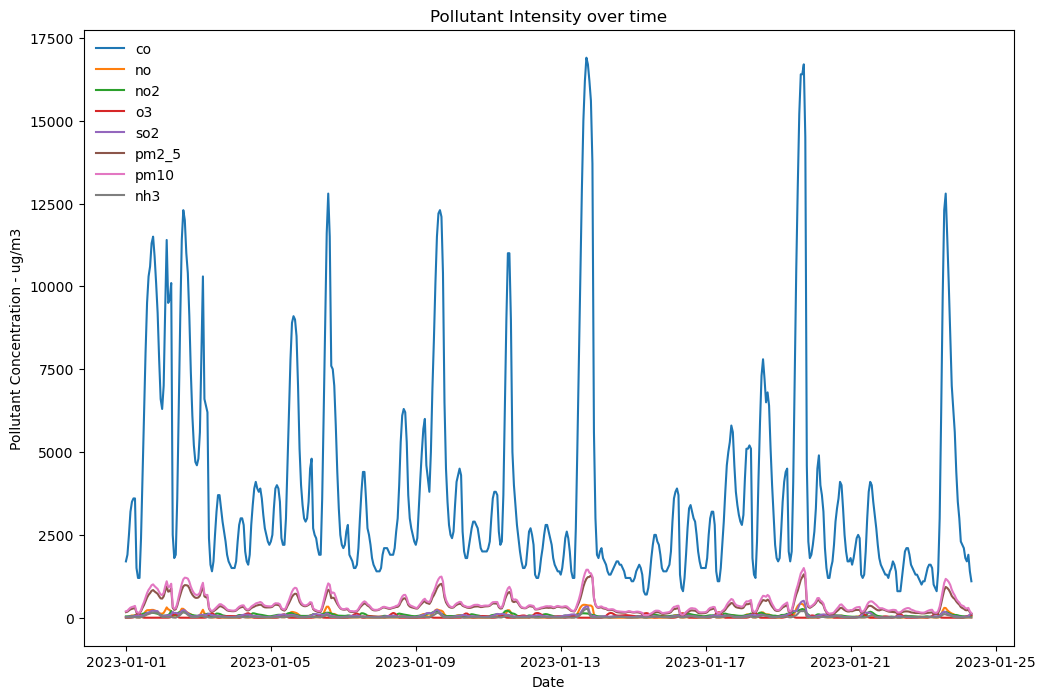

In [157]:
plt.figure(figsize = (12,8))

plt.plot(df, label = list(df.columns))
plt.xlabel('Date')
plt.ylabel('Pollutant Concentration - ug/m3')
plt.title('Pollutant Intensity over time')

plt.legend(frameon = False, fontsize="10")

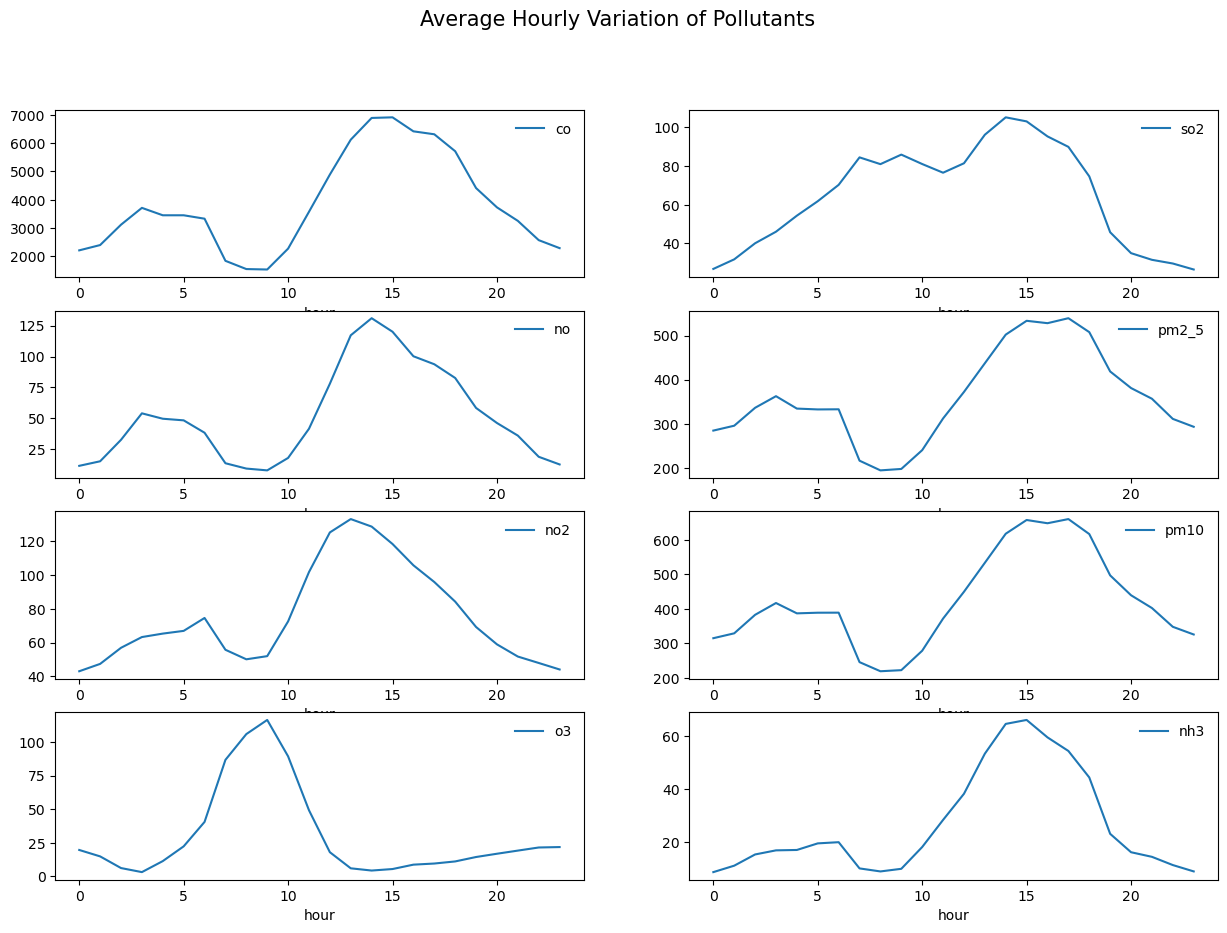

In [158]:
# hourly variation 
df['hour'] = df.index.hour
df_hr_av = df.groupby('hour').aggregate('mean')

fig, ax = plt.subplots(4,2, figsize=(15,10))
plt.suptitle('Average Hourly Variation of Pollutants', size = '15')


for col, ax in zip(df_hr_av.columns, ax.T.ravel()):
    df_hr_av[[col]].plot(ax=ax)
    ax.legend(frameon = False)

In [172]:
# Average daily AQI 
df_fin_ave= df_fin_aqi.groupby('day_of_week').aggregate('mean').round(2)
df_fin_ave.reset_index(inplace = True)

# reordering rows for proper day order 
index_list = [1,5,6,4,0,2,3]
df_fin_ave = df_fin_ave.reindex(labels=index_list)

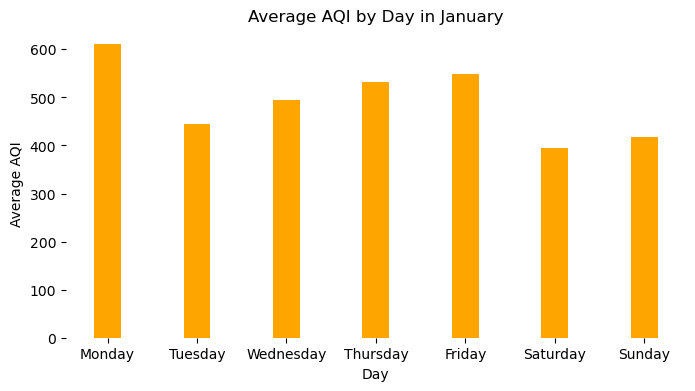

In [185]:
plt.figure(figsize=(8,4))
plt.bar(df_fin_ave.day_of_week, df_fin_ave.final_aqi, width = 0.3, color = 'orange')
plt.xlabel('Day')
plt.ylabel('Average AQI')
plt.title('Average AQI by Day in January')


for spine in plt.gca().spines.values():
    spine.set_visible(False)

In [198]:
df.query("co < 1400 & o3 > 50")

,co,no,no2,o3,so2,pm2_5,pm10,nh3,hour
datetime,,,,,,,,,
2023-01-01 08:00:00,1200.0,5.8,36.0,125.9,62.0,134.4,153.5,5.5,8
2023-01-01 09:00:00,1200.0,4.6,36.3,134.5,65.8,133.2,152.1,6.0,9
2023-01-12 07:00:00,1300.0,4.5,39.1,128.8,64.8,251.2,266.8,4.6,7
2023-01-12 08:00:00,1200.0,3.9,37.0,138.8,68.7,250.2,265.5,4.1,8
2023-01-12 09:00:00,1200.0,3.7,41.5,140.2,78.2,255.9,272.0,4.8,9
2023-01-13 08:00:00,1200.0,9.6,55.5,63.7,98.2,197.8,209.4,3.5,8
2023-01-13 09:00:00,1200.0,11.3,56.2,69.4,102.0,189.2,200.9,3.9,9
2023-01-14 08:00:00,1300.0,2.5,17.0,130.2,30.3,228.2,248.4,5.2,8
2023-01-14 09:00:00,1300.0,1.9,16.6,144.5,32.4,233.0,253.9,5.6,9
